### Setup

In [1]:
!pip install -q datasets


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from datasets import load_dataset_builder
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import time

%matplotlib inline

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E0000 00:00:1754030435.900797      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [3]:
try:
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print("Using Tpu")
except:
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print('Using GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print("Using CPU")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1754030454.985571      10 service.cc:148] XLA service 0x5bd5811d1ee0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754030454.985650      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1754030454.985655      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1754030454.985658      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1754030454.985660      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1754030454.985663      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1754030454.985665      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1754030454.985668      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1754030454.985670      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

### Download the dataset

In [4]:
dataset_path = "9wimu9/ada_derana_sinhala"
ds_builder = load_dataset_builder(dataset_path)

In [5]:
print(ds_builder.info)

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value('int64'), 'heading': Value('string'), 'content': List(Value('string'))}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='ada_derana_sinhala', config_name='default', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=418940569, num_examples=170420, shard_lengths=None, dataset_name=None)}, download_checksums=None, download_size=159392910, post_processing_size=None, dataset_size=418940569, size_in_bytes=None)


In [6]:
print(ds_builder.info.splits)

{'train': SplitInfo(name='train', num_bytes=418940569, num_examples=170420, shard_lengths=None, dataset_name=None)}


In [7]:
from datasets import load_dataset
from pathlib import Path

cache_dir = "./dataset/cache"
Path(cache_dir).mkdir(parents=True, exist_ok=True)
dataset = load_dataset(dataset_path, cache_dir=cache_dir)

Generating train split: 100%|██████████| 170420/170420 [00:01<00:00, 150763.31 examples/s]


In [8]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'heading', 'content'],
        num_rows: 170420
    })
})


In [9]:
raw_ds = dataset['train']
print(raw_ds)

Dataset({
    features: ['id', 'heading', 'content'],
    num_rows: 170420
})


### Process the text

In [10]:
content = raw_ds["content"]
print(f"Total number of rows in the raw dataset: {len(content)}")

Total number of rows in the raw dataset: 170420


In [11]:
def create_1d_list(n_d_list: list[list[str]]) -> list[str]:
    one_d_list = []
    for row in n_d_list:
        if len(row) > 1:
            for sub_row in row:
                one_d_list.append(sub_row)
        elif len(row) == 0:
            pass
        else:
            one_d_list.append(row[0])
    return one_d_list

In [12]:
text_list = create_1d_list(content)
print(f"Total number of paragraphs: {len(text_list)}")

Total number of paragraphs: 1048395


In [13]:
def get_value_counts(text: str, decode=False) -> dict:
    chars = tf.strings.unicode_split(text, input_encoding='UTF-8')
    values, counts = np.unique(chars, return_counts=True)
    counts = map(lambda x: int(x), counts)
    if decode:
        values = map(lambda x: x.decode('UTF-8'), values)
    value_counts = dict(zip(values, counts))
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

In [14]:
def clean_text(text: str, replacement: str = "") -> str:
    # lower english characters
    text = text.lower()
    # replace curly double quotes with straight double quotes
    text = re.sub(r"[\u201C\u201D]", "\u0022", text)
    # replace curly single quotes with straight single quotes
    text = re.sub(r"[\u2018\u2019]", "\u0027", text)
    # replace en-dash with dash
    text = re.sub(r"\u2013", "\u002D", text)
    # replace everything outside the allowed pattern with the replacement
    allowed_pattern = r"[a-z0-9\u0D80-\u0DFF\u200C\u200D!@#$%^&*()\[\]{}.,:;'\"<>?/\\|`~=_+ -]"
    cleaned = ''.join(char if re.match(allowed_pattern, char) else replacement for char in text)
    return cleaned

In [15]:
start = time.time()
text = ' '.join(text_list)
cleaned_text = clean_text(text)
end = time.time()

print(f"Time elapsed: {end-start} seconds")

Time elapsed: 133.1351706981659 seconds


In [16]:
print(cleaned_text[0:20000])

ගාල්ල, මාගාල්ල ප්‍ර‍ෙද්ශයේ ඉදිකර තිබූ ජාතික නිදහස් පෙරමුණේ දිස්ත්‍රික් කාර්යාලයට ඊයේ රාත්‍රී කිසියම් පිරිසක් ප්‍රහාරයක් එල්ල කර ති‍‍බේ. ප්‍රහාරය එල්ල කළ පිරිස් විසින් එම කාර්යාලයේ තිබූ බැනර් සහ කටවුට්වලට කළුතෙල් දමා ඇති බව වාර්තා ‍වේ. මේ සම්බන්ධයෙන් ජාතික නිදහස් පෙරමුණ ගාල්ල පොලිසිය වෙත පැමිණිල්ලක් ඉදිරිපත් කර ඇත. මේ අතර විපක්ෂ‍ෙය් පොදු ‍අපේක්ෂකයා සහභාගී වන රැළියක් වෙනුවෙන් මාතලේ ‍ප්‍රදේශ‍ෙය් සැරසිලි කටයුතුවල නිරතවෙමින් සිටි එක්සත් ජාතික පක්ෂ සහ ජනතා විමුක්ති පෙරමුණු ආධාරකරුවන් පිරිසකට අද අලුයම කිසියම් පිරිසක් පහර දී ති‍‍බේ. ප්‍රහාරයෙන් තුවාල ලැබූ ජනතා විමුක්ති පෙරමුණු සාමාජිකයෙකු ප්‍රතිකාර සඳහා මිහින්තලේ රෝහලට ඇතුළත් කර ඇති බව ද සඳහන් ‍‍‍‍වේ. මේ සම්බන්ධයෙන් මිහින්තලේ පොලිසිය වෙත පැමිණිල්ලක් ඉදිරිපත් කර ඇති බව වාර්තා‍‍වේ. මෙරට සෞඛ්‍ය ක්ෂේත්‍රය නගා සිටුවීමේ අරමුණින් පළාත් රෝහල් සඳහා නවීන වෛද්‍ය උපකරණ ලබාදීමේ වැඩපිළිවෙළක් සෞඛ්‍ය අමාත්‍යාංශය ආරම්භ කර තිබේ. එම අමාත්‍යාංශය පවසන පරිදි මේ යටතේ රුපියල් ‍කෝටි 250 ක නව වෛද්‍ය උපකරණ පළාත් රෝහල් වෙත ලබා‍දේ. පළාත් රෝහල්වල දැනට ඇති වෛද්‍ය උපකරණ යල් 

In [17]:
all_characters = sorted(set(text))
print(f"unique characters before cleaning: \n{all_characters}\n")
vocab = sorted(set(cleaned_text))
print(f"unique characters after cleaning: \n{vocab}\n")
print(f"vocabulary length: {len(vocab)}")

unique characters before cleaning: 
[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¥', 'ª', '«', '\xad', '®', '°', '´', 'µ', '·', '¼', '½', '¿', 'À', 'Á', 'Ç', '×', 'á', 'â', 'ã', 'ä', 'é', 'ê', 'í', 'ñ', 'ó', '÷', 'ø', 'ú', 'ü', 'ā', 'ć', 'ğ', 'İ', 'ı', 'ō', 'Œ', 'ş', 'š', 'ư', 'ɪ', 'ʀ', 'ʙ', 'ʟ', '˜', '˝', '̃', '̈', 'Ω', 'ܻ', 'ं', 'आ', 'उ', 'ए', 'क', 'ग', 'च', 'ज', 'द', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ू', 'े', 'ै', 'ो', 'இ', 'எ', 'ஐ', 'க', 'ச', 'ட', 'த', 'ந', 'ன', 'ப', 'ம', 'ய', 'ர', 'ற', 'ல', 'ள', 'வ',

In [18]:
chars = tf.strings.unicode_split(cleaned_text, input_encoding='UTF-8')
print(chars)

tf.Tensor(
[b'\xe0\xb6\x9c' b'\xe0\xb7\x8f' b'\xe0\xb6\xbd' ... b'\xe0\xb6\xba'
 b'\xe0\xb7\x92' b'.'], shape=(148840215,), dtype=string)


In [19]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=vocab, mask_token=None)

In [20]:
input_ids = ids_from_chars(chars)
input_ids

<tf.Tensor: shape=(148840215,), dtype=int64, numpy=array([ 90, 130, 121, ..., 119, 133,  15])>

In [21]:
print(ids_from_chars.get_vocabulary())

['[UNK]', np.str_(' '), np.str_('!'), np.str_('"'), np.str_('#'), np.str_('$'), np.str_('%'), np.str_('&'), np.str_("'"), np.str_('('), np.str_(')'), np.str_('*'), np.str_('+'), np.str_(','), np.str_('-'), np.str_('.'), np.str_('/'), np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(':'), np.str_(';'), np.str_('<'), np.str_('='), np.str_('>'), np.str_('?'), np.str_('@'), np.str_('['), np.str_('\\'), np.str_(']'), np.str_('^'), np.str_('_'), np.str_('`'), np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_('{'), np.str_('|'), np.str_('}'), np.str_('~'), np.str_('ං'), np.str_('

In [22]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [23]:
chars = chars_from_ids(input_ids)
chars

<tf.Tensor: shape=(148840215,), dtype=string, numpy=
array([b'\xe0\xb6\x9c', b'\xe0\xb7\x8f', b'\xe0\xb6\xbd', ...,
       b'\xe0\xb6\xba', b'\xe0\xb7\x92', b'.'], dtype=object)>

In [24]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1).numpy().decode('UTF-8')

### Create train, val and test sets

In [25]:
seq_length = 200
ids_dataset = tf.data.Dataset.from_tensor_slices(input_ids)
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [26]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [27]:
BUFFER_SIZE = 10000
full_dataset = sequences.map(split_input_target)
shuffled_dataset = full_dataset.shuffle(buffer_size=BUFFER_SIZE,
                                        reshuffle_each_iteration=False,
                                        seed=42)

In [28]:
dataset_size = tf.data.experimental.cardinality(sequences).numpy()
train_size = int(0.9 * dataset_size)
val_size = int(0.05 * dataset_size)

In [29]:
train_set = shuffled_dataset.take(train_size)
remaining = shuffled_dataset.skip(train_size)
val_set = remaining.take(val_size)
test_set = remaining.skip(val_size)

In [30]:
for input_example, target_example in train_set.take(1):
    print("Input :", text_from_ids(input_example))
    print("Target:", text_from_ids(target_example))

Input : ් වන පිළිවෙත් සහ රෙගුලාසි වලට පටහැනිව ක්‍රියාකිරීමට අදාළ චෝදනා යටතේ මෙම යුද අධිකරණයේ නඩු විභාග කෙරෙනු ඇත. පළමු යුද අධිකරණයේ විනිසුරු මඩුල්ල, දෙවන යුද අධිකරණය සඳහා ද නම් කර තිබූ අතර ඊට එල්ල වූ විරෝධතා 
Target:  වන පිළිවෙත් සහ රෙගුලාසි වලට පටහැනිව ක්‍රියාකිරීමට අදාළ චෝදනා යටතේ මෙම යුද අධිකරණයේ නඩු විභාග කෙරෙනු ඇත. පළමු යුද අධිකරණයේ විනිසුරු මඩුල්ල, දෙවන යුද අධිකරණය සඳහා ද නම් කර තිබූ අතර ඊට එල්ල වූ විරෝධතා ම


In [31]:
# To go fast on a TPU, increase the batch size. The rule of thumb is to use batches of 128 elements per core (ex: batch size of 128*8=1024 for a TPU with 8 cores)
BATCH_SIZE = 512
train_set = train_set.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
val_set = val_set.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

### Build the model

In [32]:
vocab_size = len(ids_from_chars.get_vocabulary())
embedding_dim = 256
rnn_units = 1024

In [33]:
class GRUModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                      return_sequences=True,
                                      return_state=True,
                                      reset_after=False)  # Disables CuDNN-specific behavior
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            batch_size = tf.shape(x)[0]
            states = self.gru.get_initial_state(batch_size)
        out = self.gru(x, initial_state=states, training=training)
        x, states = out
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [34]:
model = GRUModel(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)

In [35]:
for input_example_batch, target_example_batch in train_set.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape)

(512, 200, 150)


In [36]:
model.summary()

Model: "gru_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (512, 200, 256)        │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ((512, 200, 1024),     │     3,935,232 │
│                                 │ (512, 1024))           │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (512, 200, 150)        │       153,750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,127,382 (15.74 MB)

 Trainable params: 4,127,382 (15.74 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
print(sampled_indices)

[ 55  66 103  29  68  28  10 112 106 138  64 126 116  32  65  63 127 119
  32  93  60 149  78  92 117 147  93   7  10 103  47 117   9  37 112  46
  65  20   8  22  42   8  78  94 142  75  63  26 128 142  43  35 146 119
  92   2  81  72   4  96  43 118   7 101 142  56   2  64 131 136 114 125
 113  52  58  83  17  21 148 129  61 133  55   6 129  48 120  69 124   4
   2  92  83  66 144  47  56 104  76  43  43 139  54  43  83  66  44 121
  69  30  69 149  58  71  24  81  30  22  55  82   1 101  51 101  36 136
  94  68  71  73 115  85 140  33   6  52  75  65  11   6 115 110 107 138
  42  54 111  95  20   4  54  61  66  16  75 122 114  76   8 111 123  44
 141  49 127 110   0 110 123  90  30  88 130   8  93 125  94  22 119  25
 145  10  84  81 113 128 148  24  23   0 109  97  11  10  99 145  51  33
   8  93]


In [38]:
print("input:\n", text_from_ids(input_example_batch[0]))
print()
print("predictions:\n", text_from_ids(sampled_indices))

input:
 ් වන පිළිවෙත් සහ රෙගුලාසි වලට පටහැනිව ක්‍රියාකිරීමට අදාළ චෝදනා යටතේ මෙම යුද අධිකරණයේ නඩු විභාග කෙරෙනු ඇත. පළමු යුද අධිකරණයේ විනිසුරු මඩුල්ල, දෙවන යුද අධිකරණය සඳහා ද නම් කර තිබූ අතර ඊට එල්ල වූ විරෝධතා 

predictions:
 p{ඩ<};)ඳඬෙyහභ?zxළය?ඟu‍උඞමෳඟ&)ඩhම(^ඳgz3'5c'උචෝඈx9ෆෝd\ෲයඞ!ඏඅ#ජdඹ&ටෝq!yැූඵසපmsඒ04‌්vිp%්iර~ෂ#!ඞඒ{ෟhqඪඉddේodඒ{eල~=~‍sඃ7ඏ=5pඑ ටlට]ූච}ඃආබඔෛ@%mඈz*%බධතෙcoනඡ3#ov{/ඈවඵඉ'නශeොjළධ[UNK]ධශග=කා'ඟසච5ය8෦)ඓඏපෆ‌76[UNK]දඣ*)ඥ෦l@'ඟ


### Train the model

In [39]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [40]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape)
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (512, 200, 150)
Mean loss:         tf.Tensor(5.010967, shape=(), dtype=float32)


In [41]:
checkpoints_dir = "./training_checkpoints"
Path(checkpoints_dir).mkdir(parents=True, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt_{epoch}.weights.h5")

In [42]:
EPOCHS = 20

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=2,
    verbose=1,
    restore_best_weights=True
)

In [43]:
with strategy.scope():
    model = GRUModel(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=adam, loss=loss)

I0000 00:00:1754030712.861308      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [44]:
history = model.fit(train_set, validation_data=val_set, epochs=EPOCHS, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/20


I0000 00:00:1754030727.198621      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6411865025505522233
I0000 00:00:1754030727.489581     969 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2445860659298797420), session_name()
I0000 00:00:1754030729.410104     969 tpu_compile_op_common.cc:245] Compilation of 2445860659298797420 with session name  took 1.920449266s and succeeded
I0000 00:00:1754030729.415966     969 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2445860659298797420), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_6411865025505522233", property.function_library_fingerprint = 10076098872150314273, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z 

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 2.1810

I0000 00:00:1754030988.884258      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2996402740689701732
I0000 00:00:1754030988.990300     934 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2295684633380536554), session_name()
I0000 00:00:1754030990.238457     934 tpu_compile_op_common.cc:245] Compilation of 2295684633380536554 with session name  took 1.248096188s and succeeded
I0000 00:00:1754030990.240380     934 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2295684633380536554), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_2996402740689701732", property.function_library_fingerprint = 10641916975933383650, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z 

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 395s 300ms/step - loss: 2.1805 - val_loss: 1.0811
Epoch 2/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 393s 299ms/step - loss: 1.0153 - val_loss: 0.9789
Epoch 3/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 391s 298ms/step - loss: 0.9293 - val_loss: 0.9383
Epoch 4/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 397s 303ms/step - loss: 0.8906 - val_loss: 0.9163
Epoch 5/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 401s 306ms/step - loss: 0.8680 - val_loss: 0.9045
Epoch 6/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 394s 300ms/step - loss: 0.8535 - val_loss: 0.8968
Epoch 7/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 396s 301ms/step - loss: 0.8436 - val_loss: 0.8915
Epoch 8/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 395s 301ms/step - loss: 0.8365 - val_loss: 0.8886
Epoch 9/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 392s 299ms/step - loss: 0.8313 - val_loss: 0.8857
Epoch 10/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 393s 299ms/step - loss: 0.8271 - val_loss: 0.8840
Epoch 11/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 392s 299ms/step - loss: 0.8239 - val_loss: 0.88

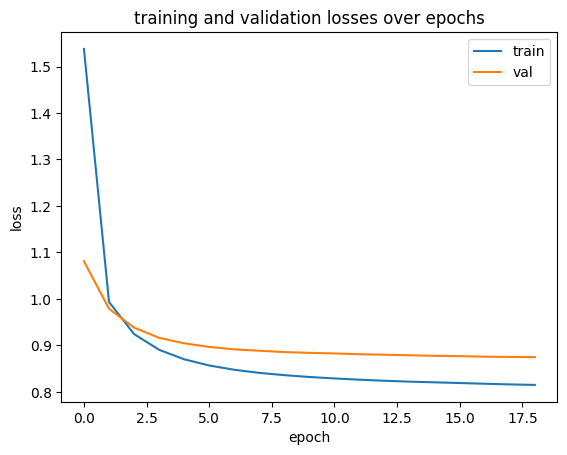

In [45]:
num_epochs = len(history.history["loss"])
plt.plot(range(num_epochs), history.history["loss"], label="train")
plt.plot(range(num_epochs), history.history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("training and validation losses over epochs")
plt.legend()
plt.show()

### Generate text

In [52]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars):
    super().__init__()
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(values=[-float('inf')]*len(skip_ids), indices=skip_ids, dense_shape=[len(self.ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None, temperature=1.0):
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)
    
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/temperature
    
    predicted_logits = predicted_logits + self.prediction_mask

    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    predicted_chars = self.chars_from_ids(predicted_ids)

    return predicted_chars, states

In [53]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [70]:
start = time.time()
states = None
next_char = tf.constant(['ජාතික'])
result = [next_char]

for n in range(10000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states, temperature=0.75)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('UTF-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ජාතිකයෙකු විසින් සිය ආයතනය වෙත භාර දී ඇත. එසේම මෙම තත්ත්වය ඇතිවෙන්නේ අද දිනයේ දී අඛණ්ඩව වර්ධනය වී තිබෙනවා. ශ්‍රී ලංකාව අත්හදා බලා තිබෙන්නේ දැනට පවතින නිදහස් අධ්‍යාපනයත්, වැඩි කරද්දී මම නීතියේ අවධානයට ලක්කරන ලෙසය. මේ අතර අගමැතිවරයාගේ අධීක්ෂණය යටතේ දැඩි පරිශ්‍රමයකින් සිදුවුණි. විරෝධතාවට සහාය දැක්වූ කසුන් පොකුර" සඳහා හෙට (11) රාත්‍රී 10 සිට පස්වරු 5 දක්වා පැය 02යි මිනිත්තු 30 තෙකරුවන් වන අතර මේ වන විට යුක්‍රේන හමුදා ඉතිහාසය වෙනුවෙන් ශ්‍රී ලංකා කණ්ඩායම වෙත පැමිණියේය. එහිදී අදහස් දක්වමින් සිරිකොත විස්සයි විස්ස ලෝක කුසලාන තරගාවලියේ පළමු තරගයේ පළමු කඩුල්ල ලෙස පැවැත්වෙනු ඇති. 2019 වසරේ නොවැම්බර් මාසයේ පැවැත්වෙන සමුළුව සඳහා සහභාගීවීමට නියමිතව තිබූ පරිසර සංවිධාන සහ ශ්‍රී ලංකාවේ ජාත්‍යන්තර මූල්‍ය අර්බුදයට විසඳුමක් ලබාදෙන ලෙස වෛද්‍යවරු ප්‍රකාශ කරයි. එම නිසා අග්‍රාමාත්‍යවරයා විසින් රුසියානු නාවික හමුදාවන් සඳහා පොදු ප්‍රවාහනය සඳහා වෙන් කරන ලද වෘත්තීය සමිති ක්‍රියාමාර්ගය අනුව පොදු ස්ථානයක් ලබාදීම සම්බන්ධයෙන් සාකච්ඡා කිරීමට නියමිතව තිබේ.   කොළඹ පැවැත්වෙන මහ බැංකු අධිපති, ජෙනරාල් සන්දිත නාහිමියන් පවසා 

### Export the generator

In [71]:
export_dir = "./saved_model"
tf.saved_model.save(one_step_model, export_dir=export_dir)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [72]:
reloaded_model = tf.saved_model.load(export_dir)

In [73]:
start = time.time()
states = None
next_char = tf.constant(['ජාතික'])
result = [next_char]

for n in range(1000):
    next_char, states = reloaded_model.generate_one_step(next_char, states=states, temperature=0.75)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('UTF-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ජාතික පක්ෂයේ ආණ්ඩුවක් පිහිටුවීම සඳහා වෙනත් ගුරුවරු ඩොලර් බිලියනයක ණය පහසුකම් ලබාගැනීමේ සුදුසු නොවන බවය. එමෙන්ම එම ප්‍රදේශ සඳහා කාලය අවශ්‍ය බව පෙනී යන බව අග්‍රාමාත්‍යවරයා පෙන්වා දෙයි. මේ අතර කාලගුණ විද්‍යා දෙපාර්තමේන්තුව නිවේදනයකර තිබුණි. එහිදී විත්තිකාර පාඨලී චම්පික රණවක මහතා තමන්ට සිරදඬුවම් නියම වූ පසු සැසිවාරය සහ පාර්ලිමේන්තු මන්ත්‍රී රනිල් වික්‍රමසිංහ මහතා විසින් විශේෂ සැසිවාර නියෝජ්‍ය සොලිසිටර් ජනරාල් දිලීප පීරිස් මහතා අභියාචනාධිකරණයට දැනුම් දී ඇති බව සඳහන් වෙයි. අධිකරණය විසින් විමර්ශනයක් ආරම්භ කර ඇත. එහිදී විත්තිකරුවන් 11 දෙනෙකු මෙම නියෝගය ලබා දී තිබේ. බස්නාහිර පළාත භාර ජ්‍යෙෂ්ඨ නියෝජ්‍ය පොලිස්පති දේශබන්දු තෙන්නකෝන් මහතාගේ නීතිඥවරු අධිකරණය හමුවේ කරුණු දක්වමින් උපදෙස් දී ඇති වාහන සඳහා ජූලි මස 10 වනදා මධ්‍යම රාත්‍රියේ සිට පැය 06කට ලක්ව තිබෙන බව පොලිස් මාධ්‍ය ප්‍රකාශක ජ්‍යෙෂ්ඨ පොලිස් අධිකාරි නිහාල් තල්දූව මහතා සඳහන් කළේය. අදාළ සිද්ධිය සම්බන්ධයෙන් විමර්ශනය සිදුකිරීම සඳහා පොලිස් කණ්ඩායම් යොවුවා භාරදී තිබුණි. වැඩිදුර විමර්ශන කටයුතු සඳහා පොලිස් කණ්ඩායම් යොදවා ඇති බව වාර්තා වෙයි. සිද්ධිය 